<a href="https://colab.research.google.com/github/chris051091/Seminario-3/blob/master/anomalias/src/Anomalias_palanquero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install windrose

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from datetime import timedelta
import matplotlib.cm as cm
from functools import reduce
from math import cos, sin, atan, pi
from windrose import WindroseAxes
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
PATH_DRIVE = 'drive/MyDrive/Seminario-3-master'
PATH_DADOS = '/preprocess/dados/'
PATH_DADOS_EVENTOS = '/dados/'
PATH_ANOMALIAS = '/anomalias/'
NOMBRE_ESTACION = 'palanquero'
FILE_DATOS_ESTACION = 'eventos_palanquero_2.csv'

LISTA_VAR = ['temp', 'hum', 'pres']
LISTA_PWV = ['pwv']
LISTA_VAR_10M = ['viento']
LISTA_PREC = ['prec']

PATH_FINAL_DADOS_TRATADOS = PATH_DRIVE + PATH_DADOS + NOMBRE_ESTACION + '/tratados/'
FILES_TRATADOS = [NOMBRE_ESTACION.lower() + f'_tratados_{VAR.lower()}.csv' for VAR in LISTA_VAR]
FILES_PWV = [NOMBRE_ESTACION.lower() + f'_tratados_{VAR.lower()}.csv' for VAR in LISTA_PWV]
FILES_TRATADOS_10M = [NOMBRE_ESTACION.lower() + f'_tratados_{VAR.lower()}.csv' for VAR in LISTA_VAR_10M]
FILES_TRATADOS_PREC = [NOMBRE_ESTACION.lower() + f'_tratados_{VAR.lower()}.csv' for VAR in LISTA_PREC]

Cargando datos de Temp, Hum, Pres

In [4]:
dfList = []
for f in FILES_TRATADOS:
  df = pd.read_csv(PATH_FINAL_DADOS_TRATADOS + f,
                  sep = ';', 
                )
  dfList.append(df)

In [5]:
df = reduce(lambda df1,df2: pd.merge(df1,df2,on='FECHA', how='outer'), dfList)
df = df.sort_values(by=['FECHA']).reset_index(drop = True)
df['HORA'] = df['FECHA'].apply(lambda x: x[11:13])

Cargando datos de Vapor de Agua

In [6]:
dfList = []
PWV_columns = []
if FILES_PWV:
    
  for f in FILES_PWV:
    dfp = pd.read_csv(PATH_FINAL_DADOS_TRATADOS + f,
                    sep = ';', 
                  )
    dfList.append(dfp)
    PWV_columns += [col for col in dfp if col != 'FECHA']


  dfPWV = reduce(lambda df1,df2: pd.merge(df1,df2,on='FECHA', how='outer'), dfList)
  dfPWV = dfPWV.sort_values(by=['FECHA']).reset_index(drop = True)

  dfPWV['FECHA_HORA'] = dfPWV['FECHA'].apply(lambda x: x[0:13])
  dfPWV = dfPWV.groupby('FECHA_HORA').agg('mean').reset_index()

  for var in PWV_columns:
    dfPWV = dfPWV.loc[~dfPWV[var].isnull()].reset_index(drop = True)

  dfPWV['FECHA'] = pd.to_datetime(dfPWV['FECHA_HORA'], format='%Y-%m-%d %H').dt.tz_localize('America/Bogota').astype(str)
else:
  dfPWV = pd.DataFrame(columns = ['FECHA'])

In [7]:
dfPWV

,FECHA_HORA,PWV,FECHA
0,2011-01-01 00,48.363636,2011-01-01 00:00:00-05:00
1,2011-01-01 01,48.830909,2011-01-01 01:00:00-05:00
2,2011-01-01 02,49.322727,2011-01-01 02:00:00-05:00
3,2011-01-01 03,48.856667,2011-01-01 03:00:00-05:00
4,2011-01-01 09,46.832000,2011-01-01 09:00:00-05:00
...,...,...,...
40050,2017-12-31 19,52.679091,2017-12-31 19:00:00-05:00
40051,2017-12-31 20,53.769091,2017-12-31 20:00:00-05:00
40052,2017-12-31 21,55.295455,2017-12-31 21:00:00-05:00
40053,2017-12-31 22,56.664545,2017-12-31 22:00:00-05:00


## Cargando datos de Vientos

$ \theta_p  = arctan(U_p / V_p) $ Direccíon del viento promedio

In [8]:
dfList = []
for f in FILES_TRATADOS_10M:
  dfaux = pd.read_csv(PATH_FINAL_DADOS_TRATADOS + f,
                  sep = ';', 
                )
  dfList.append(dfaux)

In [9]:
df10m = reduce(lambda df1,df2: pd.merge(df1,df2,on='FECHA', how='outer'), dfList)

df10m['FECHA_HORA'] = df10m['FECHA'].apply(lambda x: x[0:13])
df10m['X_VIENTO'] = df10m['VELVIENTO'] * np.sin(np.deg2rad(df10m['DIRECVIENTO'] - 180))
df10m['Y_VIENTO'] = df10m['VELVIENTO'] * np.cos(np.deg2rad(df10m['DIRECVIENTO'] - 180))

dfViento = df10m.copy()

df10m = df10m.groupby('FECHA_HORA').agg({'X_VIENTO' : 'mean', 'Y_VIENTO' : 'mean' }).reset_index()
df10m['HORA'] = df10m['FECHA_HORA'].apply(lambda x: x[11:13])
df10m['FECHA'] = pd.to_datetime(df10m['FECHA_HORA'], format='%Y-%m-%d %H').dt.tz_localize('America/Bogota').astype(str)

In [10]:
df10m

,FECHA_HORA,X_VIENTO,Y_VIENTO,HORA,FECHA
0,2011-01-02 00,-0.020676,-0.144283,00,2011-01-02 00:00:00-05:00
1,2011-01-02 01,-0.010329,-0.114271,01,2011-01-02 01:00:00-05:00
2,2011-01-02 02,-0.004356,-0.133153,02,2011-01-02 02:00:00-05:00
3,2011-01-02 03,-0.013790,-0.164974,03,2011-01-02 03:00:00-05:00
4,2011-01-02 04,-0.002036,-0.116649,04,2011-01-02 04:00:00-05:00
...,...,...,...,...,...
41343,2017-12-31 17,0.627704,-1.636584,17,2017-12-31 17:00:00-05:00
41344,2017-12-31 19,-0.112232,0.016378,19,2017-12-31 19:00:00-05:00
41345,2017-12-31 20,-0.102170,0.407207,20,2017-12-31 20:00:00-05:00
41346,2017-12-31 21,0.194049,-0.179630,21,2017-12-31 21:00:00-05:00


## Cargando datos de precipitación

In [11]:
dfList = []
PREC_columns = []
if FILES_TRATADOS_PREC:
    
  for f in FILES_TRATADOS_PREC:
    dfp = pd.read_csv(PATH_FINAL_DADOS_TRATADOS + f,
                    sep = ';', 
                  )
    dfList.append(dfp)
    PREC_columns += [col for col in dfp if col != 'FECHA']


  dfPrec = reduce(lambda df1,df2: pd.merge(df1,df2,on='FECHA', how='outer'), dfList)
  dfPrec = dfPrec.sort_values(by=['FECHA']).reset_index(drop = True)

  # dfPWV['FECHA_HORA'] = dfPWV['FECHA'].apply(lambda x: x[0:13])
  # dfPWV = dfPWV.groupby('FECHA_HORA').agg('mean').reset_index()

  for var in PREC_columns:
    dfPrec = dfPrec.loc[~dfPrec[var].isnull()].reset_index(drop = True)

  # dfPWV['FECHA'] = pd.to_datetime(dfPWV['FECHA_HORA'], format='%Y-%m-%d %H').dt.tz_localize('America/Bogota').astype(str)
else:
  dfPrec = pd.DataFrame(columns = ['FECHA'])



In [12]:
dfPrec

,FECHA,PREC
0,2011-01-01 00:10:00-05:00,0.0
1,2011-01-01 00:20:00-05:00,0.0
2,2011-01-01 00:30:00-05:00,0.0
3,2011-01-01 00:40:00-05:00,0.0
4,2011-01-01 00:50:00-05:00,0.0
...,...,...
278100,2017-12-31 23:10:00-05:00,0.0
278101,2017-12-31 23:20:00-05:00,0.0
278102,2017-12-31 23:30:00-05:00,0.0
278103,2017-12-31 23:40:00-05:00,0.0


## Cruzamiento de datos de Temp, hum y pres con PWV

In [13]:
dfDatos = pd.merge(df[['FECHA', 'TEMP', 'HUM', 'PRESION']], dfPWV[['FECHA', 'PWV']], on = 'FECHA', how = 'outer')
dfDatos['HORA'] = dfDatos['FECHA'].apply(lambda x: x[11:13])

dfmean = dfDatos.groupby('HORA').agg('mean').reset_index(level=0)

columns_mean = [col for col in dfmean.columns if col != 'HORA']
for col in columns_mean:
  dfmean = dfmean.rename(columns={col : f'{col}_mean'})

dfmean

,HORA,TEMP_mean,HUM_mean,PRESION_mean,PWV_mean
0,00,24.602023,93.996656,990.357252,55.670397
1,01,24.310280,94.871467,989.928955,55.334776
2,02,24.065277,95.213324,989.517105,54.783669
3,03,23.824669,95.952575,989.360551,54.348051
4,04,23.624545,95.860717,989.524463,53.916396
5,05,23.476396,96.446680,989.957486,53.633150
6,06,23.392489,96.118200,990.549096,53.486145
7,07,24.552886,94.378837,991.286165,53.349843
8,08,26.403856,86.492383,991.815086,53.023588
9,09,28.146848,79.125812,991.753458,52.845932


## Cargando Df de los eventos

In [14]:
dfEventos = pd.read_csv(PATH_DRIVE + PATH_DADOS_EVENTOS + FILE_DATOS_ESTACION, 
                 sep = ';'
                )
dfEventos = dfEventos.sort_values(by='date_min_t').reset_index(drop = True)
dfEventos['FECHA'] = pd.to_datetime(dfEventos['date_min_t'], format='%Y %m %d %H %M').dt.tz_localize('America/Bogota')
dfEventos['FECHA_MIN'] = dfEventos['FECHA'].dt.round('10min')  
dfEventos['FECHA'] = dfEventos['FECHA'].dt.round('H')
dfEventos = dfEventos[['FECHA', 'FECHA_MIN', 'min_t', 'lon_t', 'lat_t']]
dfEventos

,FECHA,FECHA_MIN,min_t,lon_t,lat_t
0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627
1,2011-04-09 23:00:00-05:00,2011-04-09 22:40:00-05:00,197.0,-74.693,5.627
2,2011-05-13 22:00:00-05:00,2011-05-13 22:20:00-05:00,187.8,-74.693,5.627
3,2011-06-06 22:00:00-05:00,2011-06-06 22:20:00-05:00,198.5,-74.693,5.484
4,2011-11-03 02:00:00-05:00,2011-11-03 02:20:00-05:00,191.9,-74.693,5.484
5,2011-11-06 03:00:00-05:00,2011-11-06 02:40:00-05:00,196.4,-74.693,5.627
6,2011-11-28 05:00:00-05:00,2011-11-28 04:40:00-05:00,227.3,-74.693,5.341
7,2011-12-11 03:00:00-05:00,2011-12-11 02:40:00-05:00,199.3,-74.693,5.484
8,2012-03-16 23:00:00-05:00,2012-03-16 22:40:00-05:00,193.6,-74.693,5.484
9,2012-03-20 23:00:00-05:00,2012-03-20 23:20:00-05:00,196.1,-74.693,5.627


# Cargando Eventos e encontrando intervalo n horas antes y después

In [15]:
funtime = lambda x, hour : [x + timedelta(hours = h) for h in (range(0, hour+1) if hour > 0 else range(hour, 0))]

# [base - datetime.timedelta(days=x) for x in range(numdays)]
dfEventAn = dfEventos.copy()
# pd.set_option('display.max_colwidth', None)

# ==================================
int_horas = 4
int_minutes = int_horas * 6 * 10
# ==================================
dfEventAn['FECHA_ANTES'] = dfEventAn['FECHA'].apply(funtime, hour = -int_horas)
dfEventAn['FECHA_DESPUES'] = dfEventAn['FECHA'].apply(funtime, hour = int_horas)
dfEventAn['FECHA_INTERVALO'] = dfEventAn['FECHA_ANTES'] + dfEventAn['FECHA_DESPUES']
dfEventAn = dfEventAn.drop(columns=['FECHA_ANTES', 'FECHA_DESPUES']).explode('FECHA_INTERVALO')
dfEventAn['FECHA_POS'] = (dfEventAn['FECHA_INTERVALO'] - dfEventAn['FECHA'])/ pd.Timedelta(hours=1)
dfEventAn = dfEventAn.rename(columns={'FECHA' : 'FECHA_EVENTO', 'FECHA_INTERVALO': 'FECHA'}).reset_index()
dfEventAn['FECHA'] = dfEventAn['FECHA'].astype(str)


dfEventAn.head(15)

,index,FECHA_EVENTO,FECHA_MIN,min_t,lon_t,lat_t,FECHA,FECHA_POS
0,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 19:00:00-05:00,-4.0
1,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 20:00:00-05:00,-3.0
2,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 21:00:00-05:00,-2.0
3,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 22:00:00-05:00,-1.0
4,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 23:00:00-05:00,0.0
5,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-28 00:00:00-05:00,1.0
6,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-28 01:00:00-05:00,2.0
7,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-28 02:00:00-05:00,3.0
8,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-28 03:00:00-05:00,4.0
9,1,2011-04-09 23:00:00-05:00,2011-04-09 22:40:00-05:00,197.0,-74.693,5.627,2011-04-09 19:00:00-05:00,-4.0


# Cruzamiento con las variables metereológicas. En terminos de 1h


In [16]:
dfCross = pd.merge(dfEventAn, dfDatos, on='FECHA', how = 'left')
dfCross['HORA'] = dfCross['FECHA'].apply(lambda x: x[11:13])
dfCross = pd.merge(dfCross, dfmean, on = 'HORA', how='left')

list_anomalias = []
for col in columns_mean:
  anomalia = f'{col}_anomalia'
  list_anomalias.append(anomalia)
  dfCross[anomalia] = dfCross[f'{col}'] - dfCross[f'{col}_mean'] 

dfAnomalia = dfCross[list_anomalias + ['FECHA_POS']].groupby('FECHA_POS').agg(['mean', 'std']).reset_index()

In [17]:
dfAnomalia

FECHA_POS TEMP_anomalia            ... PRESION_anomalia PWV_anomalia          
                     mean       std  ...              std         mean       std
0      -4.0      0.226235  1.320779  ...         1.224394     2.751677  3.771588
1      -3.0      0.349964  1.188915  ...         1.305966     3.256764  3.426964
2      -2.0      0.457180  1.135485  ...         1.511063     3.491419  3.138265
3      -1.0      0.393037  1.078524  ...         1.619211     3.484668  3.009741
4       0.0      0.120684  1.257764  ...         1.795704     2.735343  3.064673
5       1.0     -0.439633  1.242426  ...         1.762536     1.788008  2.997425
6       2.0     -0.531372  1.141707  ...         1.902275     1.628800  2.942431
7       3.0     -0.410947  0.987293  ...         1.845615     1.952666  3.021484
8       4.0     -0.524259  1.023989  ...         1.892017     2.064888  3.072541

[9 rows x 9 columns]

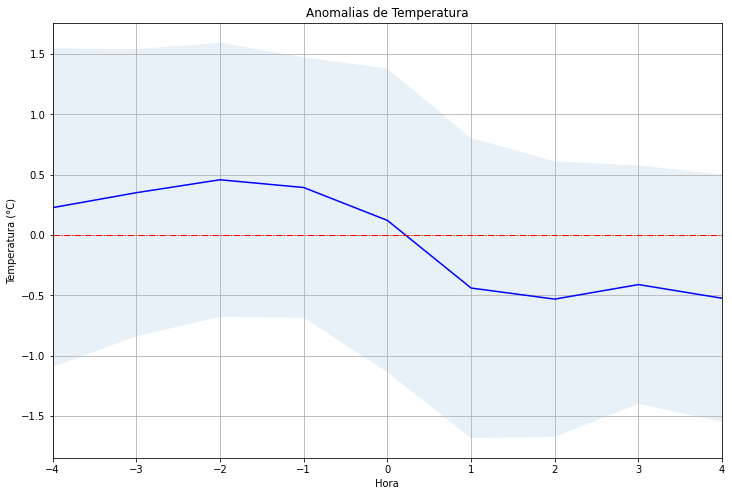

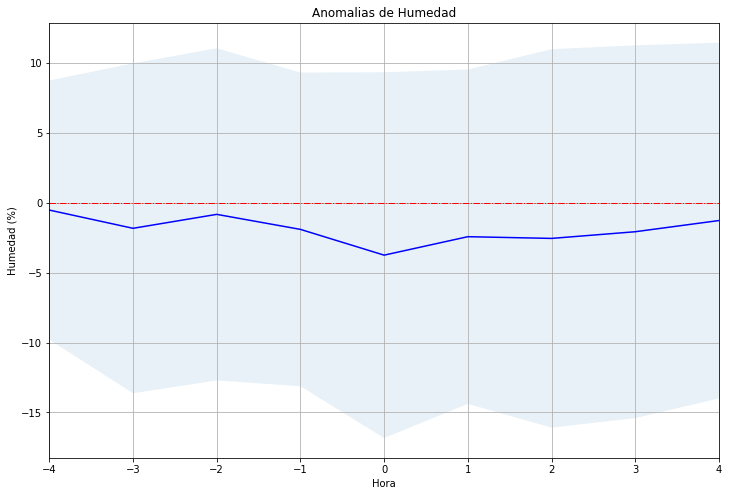

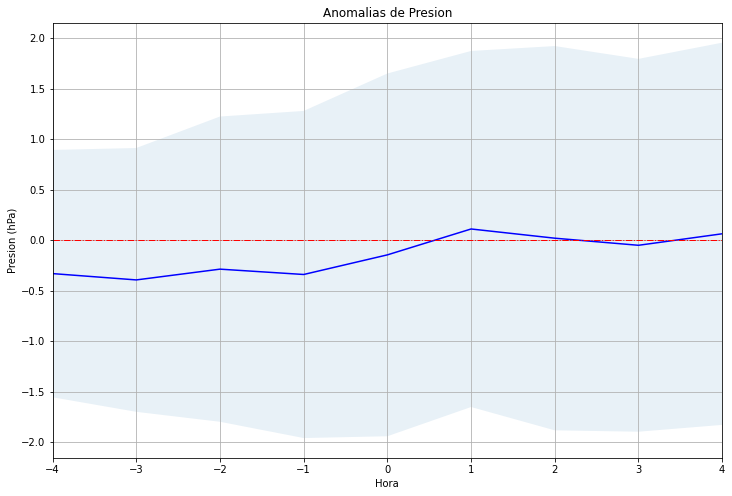

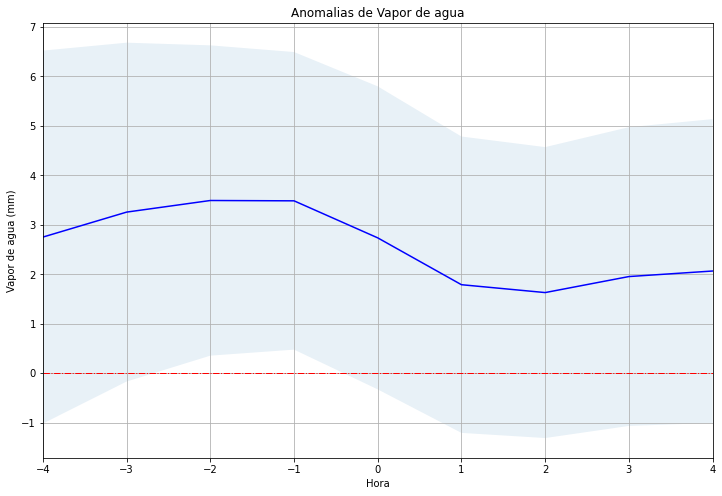

In [18]:
def plot_anomalias(df, anomalia, titulo, name_to_save, ylabel_name, int_horas, ylimit = []):
  plt.figure(figsize = (12,8))

  df['FECHA_POS'] = df['FECHA_POS'].astype(int)
  df['CERO'] = 0
  plt.xticks(df['FECHA_POS'])
  plt.plot(df['FECHA_POS'], df[(anomalia, 'mean')], color = 'b')
  plt.fill_between(df['FECHA_POS'], df[(anomalia, 'mean')] + df[(anomalia, 'std')], df[(anomalia, 'mean')] - df[(anomalia, 'std')], alpha=.1, linestyle = '--', linewidth = 0.5)
  plt.plot(df['FECHA_POS'], df['CERO'], color = 'r', linestyle = '-.', linewidth = 1)
  plt.grid()
  plt.xlim([-int_horas, int_horas])
  if ylimit:
    plt.ylim(*ylimit)
  plt.xlabel("Hora")
  plt.ylabel(ylabel_name)
  plt.title(titulo)

  plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + name_to_save, format='png', bbox_inches = 'tight' )

dict_names = {'TEMP_anomalia' : {'title' : 'Anomalias de Temperatura', 'name2save' : f'anomalias_temperatura_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : 'Temperatura (°C)'},
              'HUM_anomalia' : {'title' : 'Anomalias de Humedad', 'name2save' : f'anomalias_humedad_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : 'Humedad (%)'},
              'PRESION_anomalia' : {'title' : 'Anomalias de Presion', 'name2save' : f'anomalias_presion_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : 'Presion (hPa)'},
              'PWV_anomalia' : {'title' : 'Anomalias de Vapor de agua', 'name2save' : f'anomalias_pwv_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : 'Vapor de agua (mm)'}
    }

for key in dict_names:
  plot_anomalias(dfAnomalia, key, dict_names[key]['title'], dict_names[key]['name2save'], dict_names[key]['ylabel'], int_horas)

# dfAnomalia

# Análisis con los 21 Eventos que tienen todas las variábles metereológicas completas

In [19]:
dfEventos0 = dfCross.loc[dfCross['FECHA_POS'] == 0.]
dfEventos0 = dfEventos0[['FECHA_EVENTO', 'min_t', 'index'] + columns_mean]
dfEventos0['NUMERO_VARS'] = dfEventos0[columns_mean].notnull().sum(axis=1)
dfEventos0

,FECHA_EVENTO,min_t,index,TEMP,HUM,PRESION,PWV,NUMERO_VARS
4,2011-01-27 23:00:00-05:00,224.2,0,23.7,92.0,990.2,53.538182,4
13,2011-04-09 23:00:00-05:00,197.0,1,23.8,98.0,992.4,59.495455,4
22,2011-05-13 22:00:00-05:00,187.8,2,24.1,100.0,991.8,61.653636,4
31,2011-06-06 22:00:00-05:00,198.5,3,NaN,NaN,NaN,NaN,0
40,2011-11-03 02:00:00-05:00,191.9,4,25.6,NaN,988.4,56.503636,3
49,2011-11-06 03:00:00-05:00,196.4,5,23.7,NaN,988.9,59.640909,3
58,2011-11-28 05:00:00-05:00,227.3,6,NaN,NaN,NaN,NaN,0
67,2011-12-11 03:00:00-05:00,199.3,7,NaN,NaN,NaN,NaN,0
76,2012-03-16 23:00:00-05:00,193.6,8,NaN,NaN,NaN,NaN,0
85,2012-03-20 23:00:00-05:00,196.1,9,NaN,NaN,NaN,NaN,0


In [20]:
dfEventos0.count()

FECHA_EVENTO    51
min_t           51
index           51
TEMP            36
HUM             26
PRESION         36
PWV             32
NUMERO_VARS     51
dtype: int64

In [21]:
dfEventos0['NUMERO_VARS'].value_counts()

4    21
3    15
0    14
1     1
Name: NUMERO_VARS, dtype: int64

In [22]:
dfVarsCompletas = dfEventos0.loc[dfEventos0['NUMERO_VARS'] == 4]
indexVarsCompletas = dfVarsCompletas['index']
dfVarsComp = pd.merge(dfCross, indexVarsCompletas, on = 'index', how = 'inner')

dfAnomaliaVarsComp = dfVarsComp[list_anomalias + ['FECHA_POS']].groupby('FECHA_POS').agg(['mean', 'std']).reset_index()
dfAnomaliaVarsComp

FECHA_POS TEMP_anomalia            ... PRESION_anomalia PWV_anomalia          
                     mean       std  ...              std         mean       std
0      -4.0      0.219070  1.426882  ...         1.274862     2.083443  4.428076
1      -3.0      0.313941  1.329001  ...         1.250502     2.602140  3.969517
2      -2.0      0.277828  1.217523  ...         1.400386     2.868742  3.607619
3      -1.0      0.324550  1.136754  ...         1.531643     2.867482  3.493517
4       0.0      0.249711  1.316245  ...         1.590972     2.303907  3.536191
5       1.0     -0.401300  1.337328  ...         1.584790     1.286131  3.239916
6       2.0     -0.538283  1.121891  ...         1.755924     0.846929  2.867861
7       3.0     -0.493410  0.949121  ...         1.657401     1.129143  3.184373
8       4.0     -0.752072  0.984212  ...         1.696372     1.101938  3.227764

[9 rows x 9 columns]

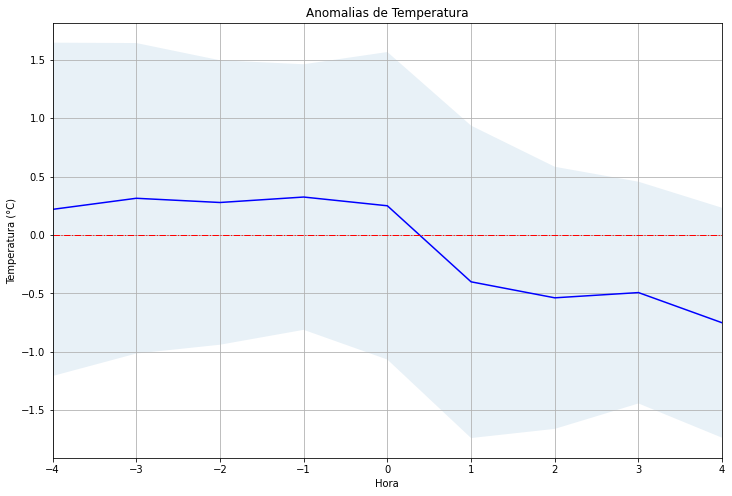

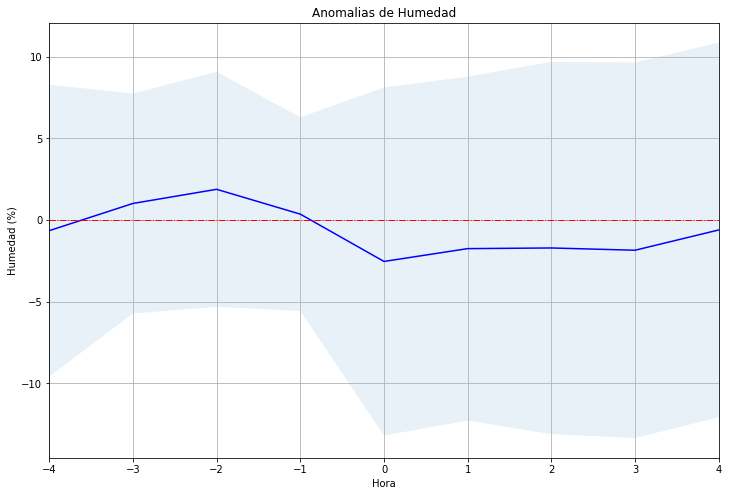

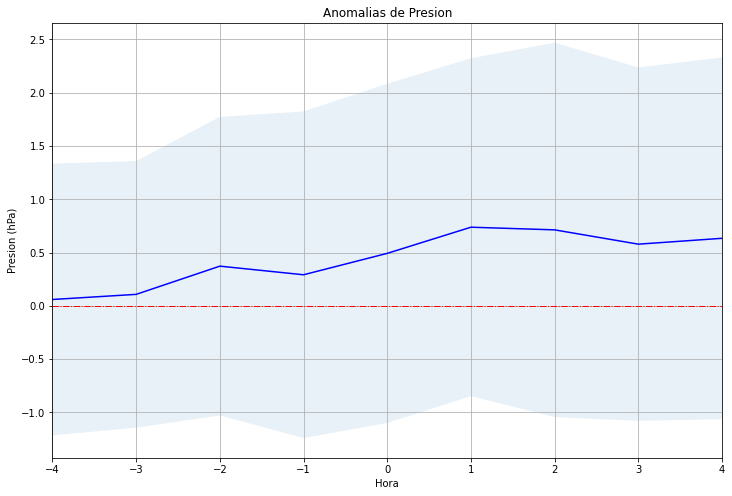

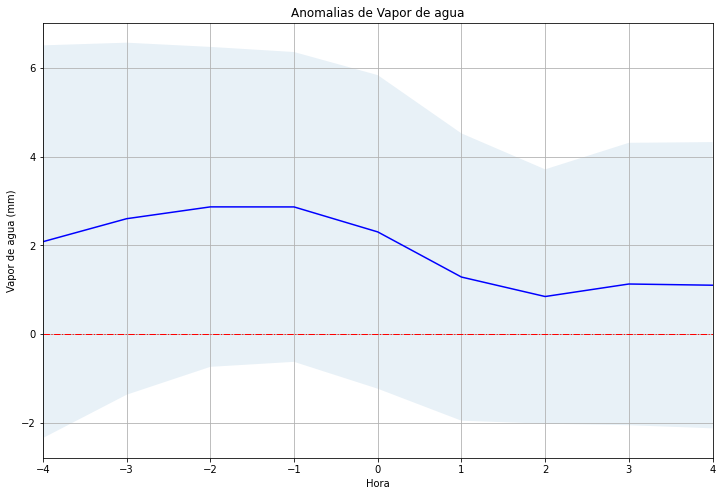

In [23]:
dict_names = {'TEMP_anomalia' : {'title' : 'Anomalias de Temperatura', 'name2save' : f'anomalias_temperatura_vars_comp_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : 'Temperatura (°C)'},
              'HUM_anomalia' : {'title' : 'Anomalias de Humedad', 'name2save' : f'anomalias_humedad_vars_comp_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : 'Humedad (%)'},
              'PRESION_anomalia' : {'title' : 'Anomalias de Presion', 'name2save' : f'anomalias_presion_vars_comp_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : 'Presion (hPa)'},
              'PWV_anomalia' : {'title' : 'Anomalias de Vapor de agua', 'name2save' : f'anomalias_pwv_vars_comp_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : 'Vapor de agua (mm)'}
    }

for key in dict_names:
  plot_anomalias(dfAnomaliaVarsComp, key, dict_names[key]['title'], dict_names[key]['name2save'], dict_names[key]['ylabel'], int_horas)

# Análisis para Dirección del Viento 

In [24]:
func_dir = lambda df, x, y: np.rad2deg(np.arctan2(df[x], df[y])) if np.arctan2(df[x], df[y]) > 0 else 360 + np.rad2deg(np.arctan2(df[x], df[y]))
func_vel = lambda df, x, y: (df[x]**2 + df[y]**2)**(1/2)

# df10mean['DIRVIENTO_mean'] = df10mean.apply(func_dir, x = 'X_VIENTO_mean', y='Y_VIENTO_mean', axis=1)
# df10mean['VELVIENTO_mean'] = df10mean.apply(func_vel, x = 'X_VIENTO_mean', y='Y_VIENTO_mean', axis=1)
df10m['DIRVIENTO'] = df10m.apply(func_dir, x = 'X_VIENTO', y='Y_VIENTO', axis=1)
df10m['VELVIENTO'] = df10m.apply(func_vel, x = 'X_VIENTO', y='Y_VIENTO', axis=1)

In [25]:
df10m

,FECHA_HORA,X_VIENTO,Y_VIENTO,HORA,FECHA,DIRVIENTO,VELVIENTO
0,2011-01-02 00,-0.020676,-0.144283,00,2011-01-02 00:00:00-05:00,188.154988,0.145757
1,2011-01-02 01,-0.010329,-0.114271,01,2011-01-02 01:00:00-05:00,185.165060,0.114737
2,2011-01-02 02,-0.004356,-0.133153,02,2011-01-02 02:00:00-05:00,181.873571,0.133225
3,2011-01-02 03,-0.013790,-0.164974,03,2011-01-02 03:00:00-05:00,184.778293,0.165550
4,2011-01-02 04,-0.002036,-0.116649,04,2011-01-02 04:00:00-05:00,181.000000,0.116667
...,...,...,...,...,...,...,...
41343,2017-12-31 17,0.627704,-1.636584,17,2017-12-31 17:00:00-05:00,159.015918,1.752832
41344,2017-12-31 19,-0.112232,0.016378,19,2017-12-31 19:00:00-05:00,278.302416,0.113421
41345,2017-12-31 20,-0.102170,0.407207,20,2017-12-31 20:00:00-05:00,345.914990,0.419829
41346,2017-12-31 21,0.194049,-0.179630,21,2017-12-31 21:00:00-05:00,132.790163,0.264428


# Cargando Eventos e encontrando intervalo m minutos antes y después

In [26]:
funtimeMinutes = lambda x, minute : [x + timedelta(minutes = h) for h in (range(0, minute+1, 10) if minute > 0 else range(minute, 0, 10))]

dfEventAnMin = dfEventos.copy()

dfEventAnMin['FECHA_ANTES_MIN'] = dfEventAnMin['FECHA_MIN'].apply(funtimeMinutes, minute = -int_minutes)
dfEventAnMin['FECHA_DESPUES_MIN'] = dfEventAnMin['FECHA_MIN'].apply(funtimeMinutes, minute = int_minutes)

dfEventAnMin['FECHA_INTERVALO'] = dfEventAnMin['FECHA_ANTES_MIN'] + dfEventAnMin['FECHA_DESPUES_MIN']
dfEventAnMin = dfEventAnMin.drop(columns=['FECHA_ANTES_MIN', 'FECHA_DESPUES_MIN']).explode('FECHA_INTERVALO')
dfEventAnMin['FECHA_POS'] = (dfEventAnMin['FECHA_INTERVALO'] - dfEventAnMin['FECHA_MIN'])/ pd.Timedelta(minutes=1)
dfEventAnMin = dfEventAnMin.rename(columns={'FECHA_MIN' : 'FECHA_EVENTO', 'FECHA': 'FECHA_HORA', 'FECHA_INTERVALO': 'FECHA'}).reset_index(drop=True)
dfEventAnMin['FECHA'] = dfEventAnMin['FECHA'].astype(str)

dfEventAnMin.head(10)

,FECHA_HORA,FECHA_EVENTO,min_t,lon_t,lat_t,FECHA,FECHA_POS
0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 19:20:00-05:00,-240.0
1,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 19:30:00-05:00,-230.0
2,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 19:40:00-05:00,-220.0
3,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 19:50:00-05:00,-210.0
4,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 20:00:00-05:00,-200.0
5,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 20:10:00-05:00,-190.0
6,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 20:20:00-05:00,-180.0
7,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 20:30:00-05:00,-170.0
8,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 20:40:00-05:00,-160.0
9,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 20:50:00-05:00,-150.0


In [27]:
dfCrossPrec = pd.merge(dfEventAnMin, dfPrec, on='FECHA', how = 'left')

dfCrossPrecGroup = dfCrossPrec.groupby("FECHA_POS").agg({"PREC" : ["mean", "std"]})
dfCrossPrecGroup = dfCrossPrecGroup.rename(columns = {("PREC", "mean") : "PREC_mean", ("PREC", "std") : "PREC_std"}).reset_index()

dfCrossPrecGroup

FECHA_POS      PREC          
                  mean       std
0     -240.0  0.283784  1.726189
1     -230.0  0.172973  1.052154
2     -220.0  0.021622  0.115795
3     -210.0  0.013889  0.083333
4     -200.0  0.011111  0.052251
5     -190.0  0.005556  0.033333
6     -180.0  0.350000  2.032100
7     -170.0  0.358333  1.733926
8     -160.0  0.188889  0.793105
9     -150.0  0.059459  0.313102
10    -140.0  0.045946  0.160891
11    -130.0  0.054054  0.266244
12    -120.0  0.040541  0.214035
13    -110.0  0.044444  0.234758
14    -100.0  0.055556  0.269862
15     -90.0  0.055556  0.252354
16     -80.0  0.077778  0.373486
17     -70.0  0.151429  0.810364
18     -60.0  0.137143  0.459594
19     -50.0  0.352778  1.135275
20     -40.0  0.200000  0.489314
21     -30.0  0.488889  1.683157
22     -20.0  0.830556  2.901804
23     -10.0  1.119444  2.702149
24       0.0  0.975000  3.025924
25      10.0  1.405556  3.732326
26      20.0  1.477778  3.697575
27      30.0  1.008333  2.686833
28      40.0  0.800000  2.362807
29      50.0  0.772222  1.937098
30      60.0  0.705556  1.868681
31      70.0  0.200000  0.453382
32      80.0  0.237838  0.792798
33      90.0  0.488889  2.225024
34     100.0  0.402778  1.544666
35     110.0  0.288889  0.863474
36     120.0  0.302703  0.979934
37     130.0  0.189189  0.392134
38     140.0  0.508108  2.245165
39     150.0  0.278378  0.900350
40     160.0  0.210811  0.632361
41     170.0  0.116216  0.232753
42     180.0  0.105405  0.251601
43     190.0  0.157143  0.616101
44     200.0  0.137143  0.546155
45     210.0  0.065714  0.226148
46     220.0  0.097143  0.473091
47     230.0  0.051429  0.188448
48     240.0  0.022857  0.059832

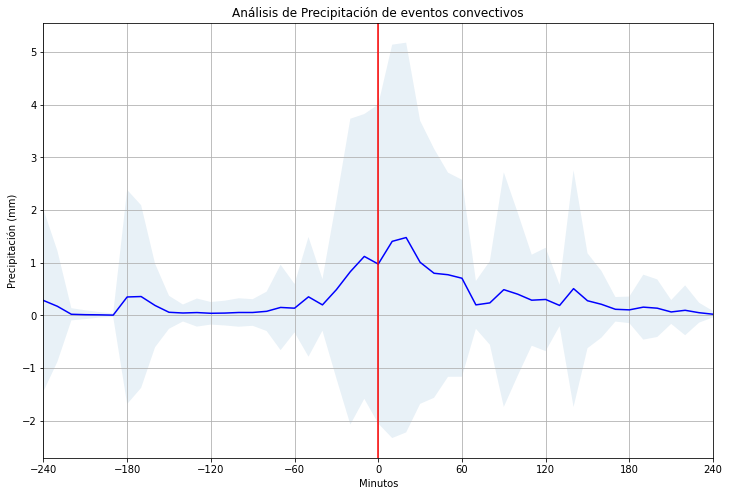

In [28]:
def plot_10m_interval(df, campo, titulo, name_to_save, ylabel_name, int_minutes, ylimit = [], has_std = True):
  plt.figure(figsize = (12,8))

  df['FECHA_POS'] = df['FECHA_POS'].astype(int)
  df['CERO'] = 0
  frequency = 6
  plt.xticks(df['FECHA_POS'][::frequency])
  if has_std:
    plt.plot(df['FECHA_POS'], df[(campo, 'mean')], color = 'b')
    plt.fill_between(df['FECHA_POS'], df[(campo, 'mean')] + df[(campo, 'std')], df[(campo, 'mean')] - df[(campo, 'std')], alpha=.1, linestyle = '--', linewidth = 0.5)
  else:
    plt.plot(df['FECHA_POS'], df[campo], color = 'b')
  # plt.plot(df['FECHA_POS'], df['CERO'], color = 'r', linestyle = '-.', linewidth = 1)
  plt.grid()
  plt.axvline(color = 'r')
  plt.xlim([-int_minutes, int_minutes])
  if ylimit:
    plt.ylim(*ylimit)
  plt.xlabel("Minutos")
  plt.ylabel(ylabel_name)
  plt.title(titulo)

  plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + name_to_save, format='png', bbox_inches = 'tight' )

dict_names = {'PREC' : {'title' : 'Análisis de Precipitación de eventos convectivos', 'name2save' : f'analisis_prec_{NOMBRE_ESTACION}_{int_minutes}m.png', 'ylabel' : 'Precipitación (mm)'},

    }

for key in dict_names.keys():
  plot_10m_interval(dfCrossPrecGroup, key, dict_names[key]['title'], dict_names[key]['name2save'], dict_names[key]['ylabel'], int_minutes)


# Análisis de Viento

In [29]:
func_dir = lambda df, x, y: np.rad2deg(np.arctan2(df[x], df[y])) if np.arctan2(df[x], df[y]) > 0 else 360 + np.rad2deg(np.arctan2(df[x], df[y]))
func_vel = lambda df, x, y: (df[x]**2 + df[y]**2)**(1/2)

In [30]:
dfCrossVientos = pd.merge(dfEventAnMin, dfViento, on='FECHA', how = 'left')

dfCrossVientosGroup = dfCrossVientos.groupby("FECHA_POS").agg({"X_VIENTO" : "mean", "Y_VIENTO" : "mean"}).reset_index()
# dfCrossPrecGroup = dfCrossPrecGroup.rename(columns = {("PREC", "mean") : "PREC_mean", ("PREC", "std") : "PREC_std"}).reset_index()

dfCrossVientosGroup['DIR_VIENTO'] = dfCrossVientosGroup.apply(func_dir, x = 'X_VIENTO', y='Y_VIENTO', axis=1)
dfCrossVientosGroup['DIR_VIENTO'] = (dfCrossVientosGroup['DIR_VIENTO'] + 180.0) % 360
dfCrossVientosGroup['VEL_VIENTO'] = dfCrossVientosGroup.apply(func_vel, x = 'X_VIENTO', y='Y_VIENTO', axis=1)

dfCrossVientosGroup


,FECHA_POS,X_VIENTO,Y_VIENTO,DIR_VIENTO,VEL_VIENTO
0,-240.0,0.053201,-0.145679,339.938098,0.155089
1,-230.0,-0.060459,-0.321127,10.662323,0.326769
2,-220.0,-0.009133,-0.263507,1.984948,0.263665
3,-210.0,-0.047025,-0.369129,7.260079,0.372113
4,-200.0,-0.032163,-0.266819,6.873329,0.268751
5,-190.0,-0.125109,-0.193254,32.918188,0.230216
6,-180.0,-0.049897,-0.111444,24.119504,0.122104
7,-170.0,-0.097429,-0.255498,20.873317,0.273444
8,-160.0,-0.052081,-0.110097,25.316151,0.121794
9,-150.0,-0.263888,-0.057550,77.697314,0.270090


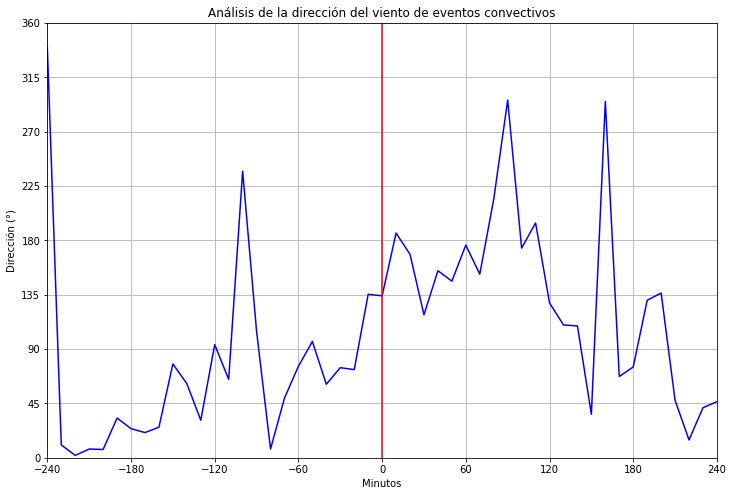

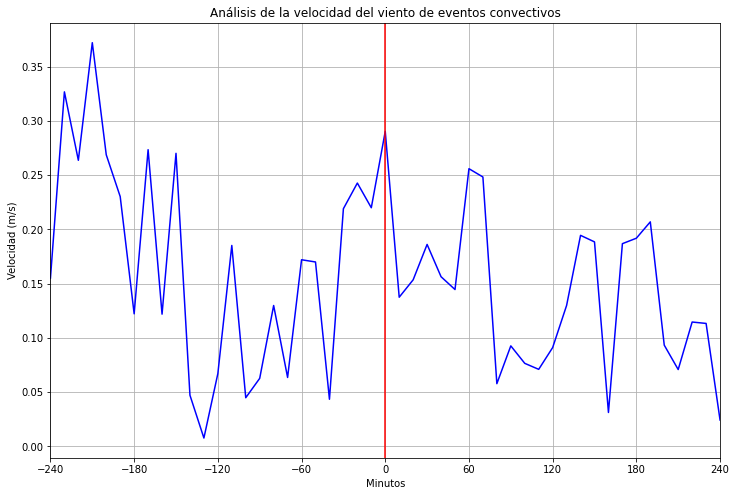

In [31]:
def plot_dir_viento_interval(df, campo, titulo, name_to_save, ylabel_name, int_minutes, ylimit = [], has_std = True):
  plt.figure(figsize = (12,8))

  df['FECHA_POS'] = df['FECHA_POS'].astype(int)
  df['CERO'] = 0
  frequency = 6
  plt.xticks(df['FECHA_POS'][::frequency])
  plt.yticks(range(0, 361, 45))
  if has_std:
    plt.plot(df['FECHA_POS'], df[(campo, 'mean')], color = 'b')
    plt.fill_between(df['FECHA_POS'], df[(campo, 'mean')] + df[(campo, 'std')], df[(campo, 'mean')] - df[(campo, 'std')], alpha=.1, linestyle = '--', linewidth = 0.5)
  else:
    plt.plot(df['FECHA_POS'], df[campo], color = 'b')
  plt.grid()
  plt.axvline(color = 'r')
  plt.xlim([-int_minutes, int_minutes])
  if ylimit:
    plt.ylim(*ylimit)
  plt.xlabel("Minutos")
  plt.ylabel(ylabel_name)
  plt.title(titulo)

  plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + name_to_save, format='png', bbox_inches = 'tight' )

dict_names = {'DIR_VIENTO' : {'title' : 'Análisis de la dirección del viento de eventos convectivos', 'name2save' : f'analisis_dir_viento_{NOMBRE_ESTACION}_{int_minutes}m.png', 'ylabel' : 'Dirección (°)'},
              'VEL_VIENTO' : {'title' : 'Análisis de la velocidad del viento de eventos convectivos', 'name2save' : f'analisis_vel_viento_{NOMBRE_ESTACION}_{int_minutes}m.png', 'ylabel' : 'Velocidad (m/s)'},
             }

key = 'DIR_VIENTO'
plot_dir_viento_interval(dfCrossVientosGroup, key, dict_names[key]['title'], dict_names[key]['name2save'], dict_names[key]['ylabel'], int_minutes, ylimit = [0, 360], has_std=False)

key = 'VEL_VIENTO'
plot_10m_interval(dfCrossVientosGroup, key, dict_names[key]['title'], dict_names[key]['name2save'], dict_names[key]['ylabel'], int_minutes, has_std=False)

In [32]:
df10m

,FECHA_HORA,X_VIENTO,Y_VIENTO,HORA,FECHA,DIRVIENTO,VELVIENTO
0,2011-01-02 00,-0.020676,-0.144283,00,2011-01-02 00:00:00-05:00,188.154988,0.145757
1,2011-01-02 01,-0.010329,-0.114271,01,2011-01-02 01:00:00-05:00,185.165060,0.114737
2,2011-01-02 02,-0.004356,-0.133153,02,2011-01-02 02:00:00-05:00,181.873571,0.133225
3,2011-01-02 03,-0.013790,-0.164974,03,2011-01-02 03:00:00-05:00,184.778293,0.165550
4,2011-01-02 04,-0.002036,-0.116649,04,2011-01-02 04:00:00-05:00,181.000000,0.116667
...,...,...,...,...,...,...,...
41343,2017-12-31 17,0.627704,-1.636584,17,2017-12-31 17:00:00-05:00,159.015918,1.752832
41344,2017-12-31 19,-0.112232,0.016378,19,2017-12-31 19:00:00-05:00,278.302416,0.113421
41345,2017-12-31 20,-0.102170,0.407207,20,2017-12-31 20:00:00-05:00,345.914990,0.419829
41346,2017-12-31 21,0.194049,-0.179630,21,2017-12-31 21:00:00-05:00,132.790163,0.264428


# Análisis de viento por hora

In [33]:
dfCrossVientosHora = pd.merge(dfEventAn, df10m, on='FECHA', how = 'left')

dfCrossVientosHora
# dfCrossVientosHoraGroup = dfCrossVientosHora.groupby("FECHA_POS").agg({"X_VIENTO" : "mean", "Y_VIENTO" : "mean"}).reset_index()

dfCrossVientosHora['DIR_VIENTO'] = dfCrossVientosHora.apply(func_dir, x = 'X_VIENTO', y='Y_VIENTO', axis=1)
dfCrossVientosHora['DIR_VIENTO'] = (dfCrossVientosHora['DIR_VIENTO'] + 180.0) % 360
dfCrossVientosHora['VEL_VIENTO'] = dfCrossVientosHora.apply(func_vel, x = 'X_VIENTO', y='Y_VIENTO', axis=1)

dfCrossVientosHora

,index,FECHA_EVENTO,FECHA_MIN,min_t,lon_t,lat_t,FECHA,FECHA_POS,FECHA_HORA,X_VIENTO,Y_VIENTO,HORA,DIRVIENTO,VELVIENTO,DIR_VIENTO,VEL_VIENTO
0,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 19:00:00-05:00,-4.0,2011-01-27 19,-0.003839,-0.139930,19,181.571393,0.139983,1.571393,0.139983
1,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 20:00:00-05:00,-3.0,2011-01-27 20,-0.005777,-0.116156,20,182.847375,0.116300,2.847375,0.116300
2,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 21:00:00-05:00,-2.0,2011-01-27 21,-0.035036,-0.129471,21,195.142119,0.134127,15.142119,0.134127
3,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 22:00:00-05:00,-1.0,2011-01-27 22,-0.031155,-0.098454,22,197.559407,0.103265,17.559407,0.103265
4,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 23:00:00-05:00,0.0,2011-01-27 23,-0.046361,-0.131477,23,199.423529,0.139412,19.423529,0.139412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454,50,2017-11-14 01:00:00-05:00,2017-11-14 00:40:00-05:00,196.1,-74.693,5.627,2017-11-14 01:00:00-05:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
455,50,2017-11-14 01:00:00-05:00,2017-11-14 00:40:00-05:00,196.1,-74.693,5.627,2017-11-14 02:00:00-05:00,1.0,2017-11-14 02,0.115068,-0.585969,02,168.890042,0.597161,348.890042,0.597161
456,50,2017-11-14 01:00:00-05:00,2017-11-14 00:40:00-05:00,196.1,-74.693,5.627,2017-11-14 03:00:00-05:00,2.0,2017-11-14 03,-0.239530,-0.607192,03,201.528600,0.652730,21.528600,0.652730
457,50,2017-11-14 01:00:00-05:00,2017-11-14 00:40:00-05:00,196.1,-74.693,5.627,2017-11-14 04:00:00-05:00,3.0,2017-11-14 04,-0.786721,0.552925,04,305.100419,0.961590,125.100419,0.961590


In [56]:
def plot_windrose(df, title, path_to_save):
  ax = WindroseAxes.from_ax()

  ax.bar(df['DIR_VIENTO'], df['VEL_VIENTO'], normed=True, opening=0.8, bins=np.arange(0.0, 5, 0.5), edgecolor='white', cmap=cm.cool)
  ax.set_legend(loc = 3)
  ax.set_xticklabels(['E', 'NE', 'N', 'NW',  'W', 'SW', 'S', 'SE'])
  plt.title(title)
  plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + path_to_save, format='png', bbox_inches = 'tight' )
  plt.show()

In [57]:
posHoras = set(list(dfCrossVientosHora['FECHA_POS']))
posHoras

{-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0}

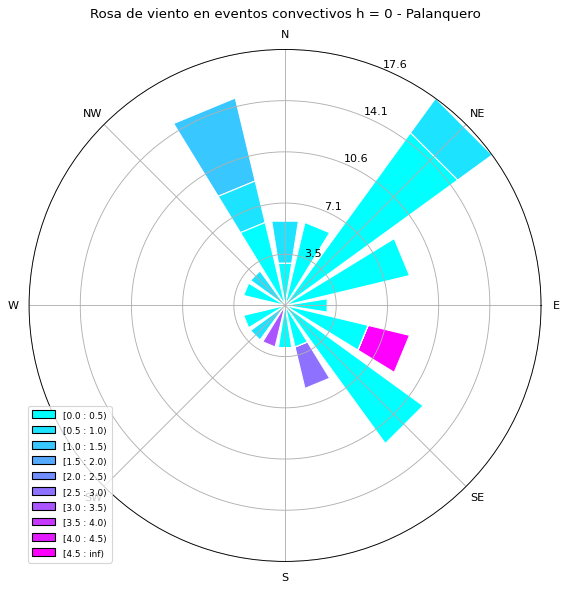

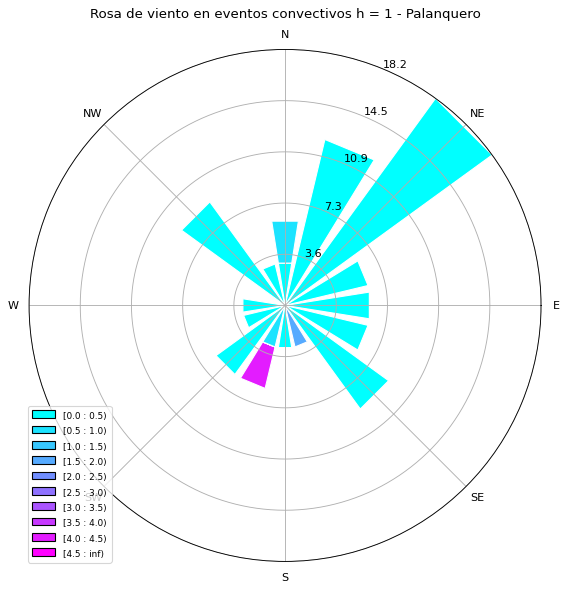

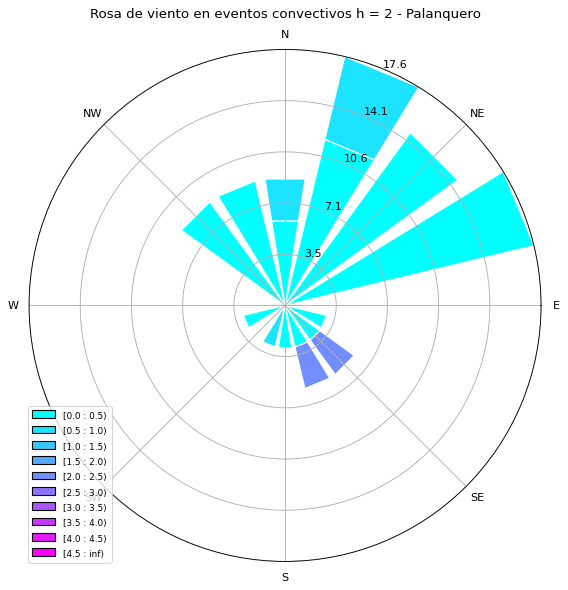

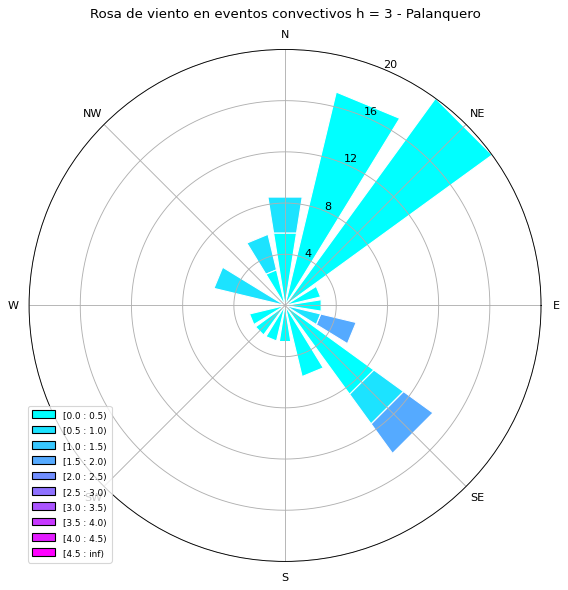

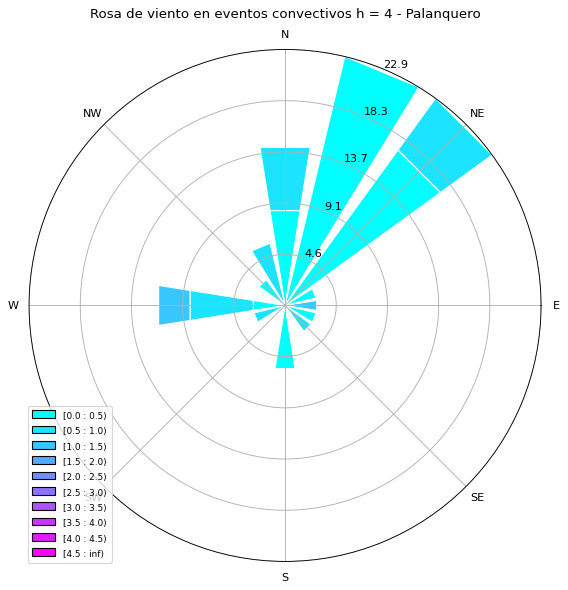

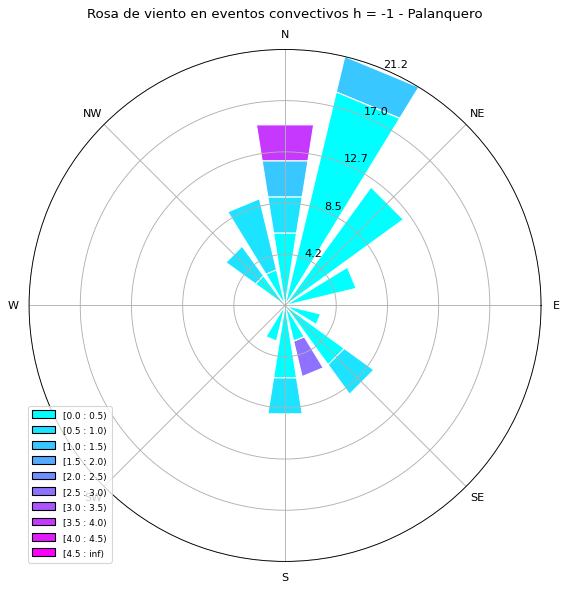

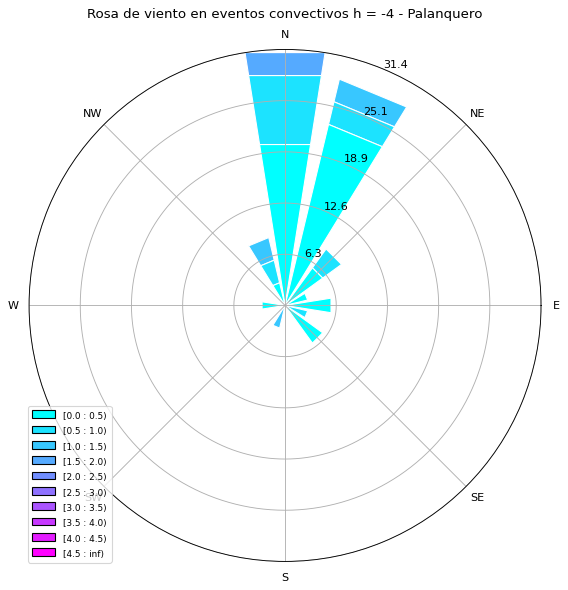

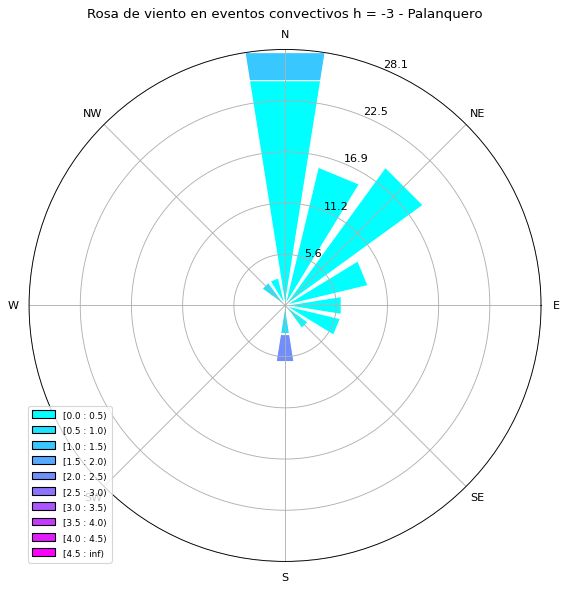

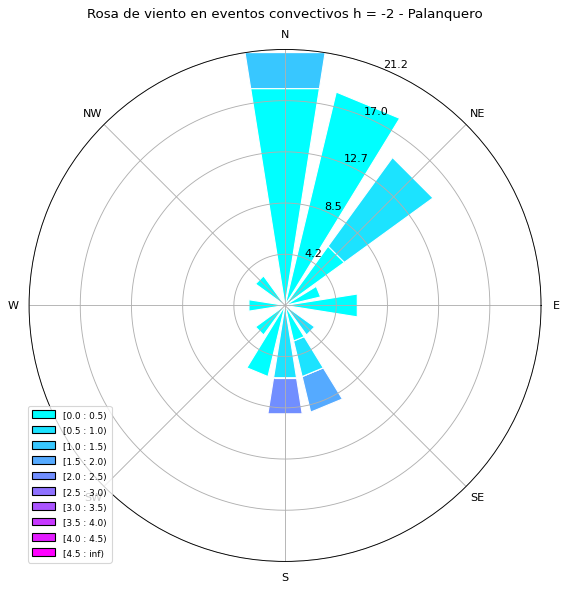

In [58]:
for hora in posHoras:
  dft = dfCrossVientosHora.loc[dfCrossVientosHora['FECHA_POS'] == hora]
  title = f'Rosa de viento en eventos convectivos h = {int(hora)} - {NOMBRE_ESTACION.capitalize()}'
  path_to_save = f'windrose_eventos_convectivos_hora_{int(hora)}_{NOMBRE_ESTACION.lower()}.png'
    
  plot_windrose(dft, title, path_to_save)

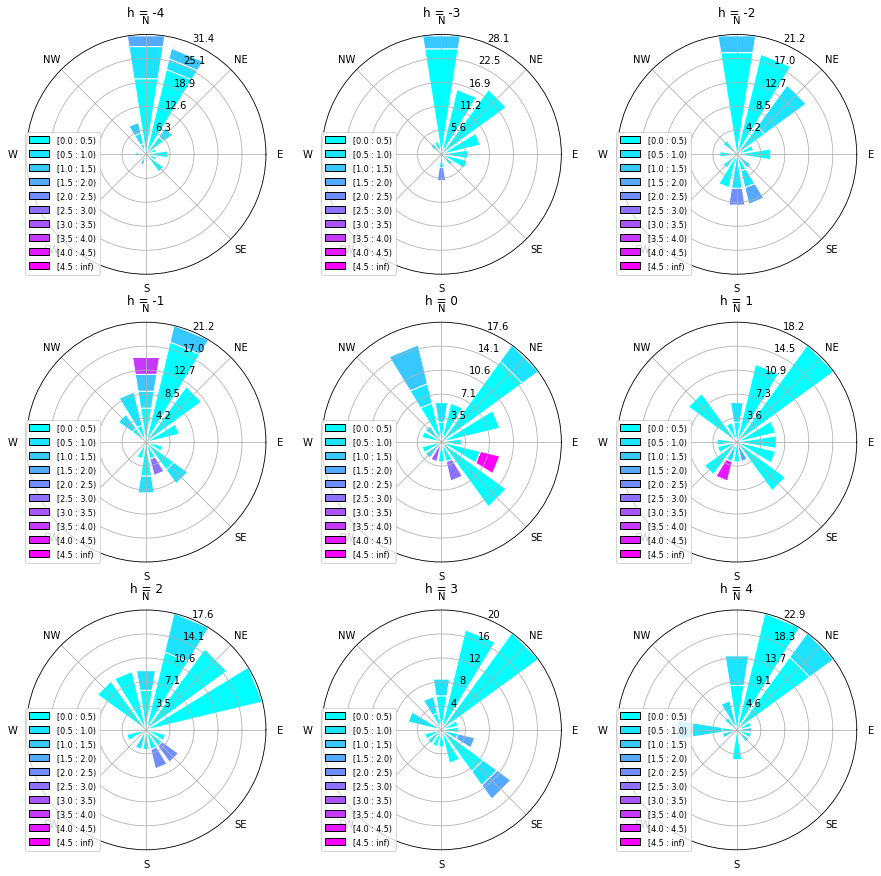

In [55]:
def plot_windrose_2(df, title, ax):
  ax.bar(df['DIR_VIENTO'], df['VEL_VIENTO'], normed=True, opening=0.8, bins=np.arange(0.0, 5, 0.5), edgecolor='white', cmap=cm.cool)
  ax.set_legend(loc = 3)
  ax.set_xticklabels(['E', 'NE', 'N', 'NW',  'W', 'SW', 'S', 'SE'])
  ax.set_title(title)


fig, axs = plt.subplots(3, 3,figsize=(15,15),  subplot_kw=dict(projection="windrose"))
horas = list(posHoras)
horas.sort()

for ax, hora in zip(axs.reshape(9), horas):
  dft = dfCrossVientosHora.loc[dfCrossVientosHora['FECHA_POS'] == hora]
  title = f'h = {int(hora)}'
  plot_windrose_2(dft, title, ax)

path_to_save = f'subplot_vientos_{NOMBRE_ESTACION}.png'
plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + path_to_save, format='png', bbox_inches = 'tight' )
plt.show()

# Gráficos multivariables en único Plot

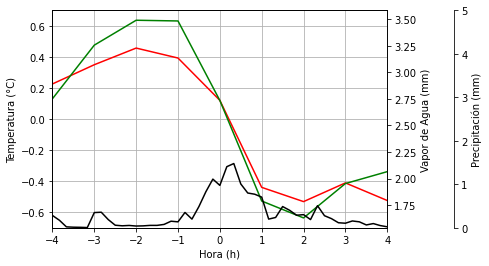

In [38]:
fig, ax = plt.subplots()
ax.plot(dfAnomalia['FECHA_POS'], dfAnomalia[('TEMP_anomalia', 'mean')], c = 'red')
ax.set_ylim(-0.7, 0.7)

ax2=ax.twinx()
ax2.plot(dfAnomalia['FECHA_POS'], dfAnomalia[('PWV_anomalia', 'mean')], c = 'green')

ax3=ax.twinx()
ax3.spines['right'].set_position(('axes', 1.2))
ax3.plot(dfCrossPrecGroup['FECHA_POS']/60.0, dfCrossPrecGroup[('PREC', 'mean')], c = 'black')
ax3.set_ylim(0, 5)

ax.set_xlim(-4, 4)
ax.grid()

ax.set_ylabel("Temperatura (°C)")
ax2.set_ylabel("Vapor de Agua (mm)")
ax3.set_ylabel("Precipitación (mm)")
ax.set_xlabel("Hora (h)")

path_to_save = f'temp_vs_pwv_vs_prec_anomalias_{NOMBRE_ESTACION}.png'
plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + path_to_save, format='png', bbox_inches = 'tight' )

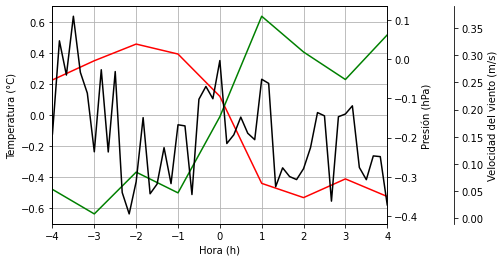

In [39]:
fig, ax = plt.subplots()
ax.plot(dfAnomalia['FECHA_POS'], dfAnomalia[('TEMP_anomalia', 'mean')], c = 'red')
ax.set_ylim(-0.7, 0.7)

ax2=ax.twinx()
ax2.plot(dfAnomalia['FECHA_POS'], dfAnomalia[('PRESION_anomalia', 'mean')], c = 'green')

ax3=ax.twinx()
ax3.spines['right'].set_position(('axes', 1.2))
ax3.plot(dfCrossVientosGroup['FECHA_POS']/60.0, dfCrossVientosGroup['VEL_VIENTO'], c = 'black')
# ax3.set_ylim(0, 0.5)

ax.set_xlim(-4, 4)
ax.grid()

ax.set_ylabel("Temperatura (°C)")
ax2.set_ylabel("Presión (hPa)")
ax3.set_ylabel("Velocidad del viento (m/s)")
ax.set_xlabel("Hora (h)")

path_to_save = f'temp_vs_pres_vs_velviento_anomalias_{NOMBRE_ESTACION}.png'
plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + path_to_save, format='png', bbox_inches = 'tight' )